In [1]:
import asyncio
import websockets
import json
import nest_asyncio
import asyncio
async def rate_limited_get_iv(instrument_names):
    results = {}
    for name in instrument_names:
        try:
            iv = await get_implied_volatility(name)
            results[name] = iv
            await asyncio.sleep(0.1)  # 延迟100ms避免限流
        except Exception as e:
            print(f"Error fetching IV for {name}: {e}")
    return results


nest_asyncio.apply()
# Here I use get instrument to get all the infomation related with currently listed BTC Option instruments 
async def get_instruments():
    uri = "wss://www.deribit.com/ws/api/v2"  
    request = {
        "jsonrpc": "2.0",
        "id": 1,
        "method": "public/get_instruments",
        "params": {
            "currency": "BTC",
            "kind": "option",
            "expired": False
        }
    }
    async with websockets.connect(uri) as websocket:
        await websocket.send(json.dumps(request))
        response = await websocket.recv()
        data = json.loads(response)
        return data['result']

instruments = asyncio.run(get_instruments())
print(f"Total BTC options: {len(instruments)}")
for instrument in instruments[:]:  
    print(instrument)


Total BTC options: 902
{'tick_size_steps': [{'above_price': 0.005, 'tick_size': 0.0005}], 'quote_currency': 'BTC', 'min_trade_amount': 0.1, 'counter_currency': 'USD', 'settlement_currency': 'BTC', 'block_trade_min_trade_amount': 25, 'block_trade_commission': 0.0003, 'option_type': 'call', 'settlement_period': 'week', 'creation_timestamp': 1730383380000, 'instrument_id': 385097, 'base_currency': 'BTC', 'block_trade_tick_size': 0.0001, 'tick_size': 0.0001, 'contract_size': 1.0, 'strike': 56000.0, 'is_active': True, 'expiration_timestamp': 1732262400000, 'instrument_type': 'reversed', 'taker_commission': 0.0003, 'maker_commission': 0.0003, 'instrument_name': 'BTC-22NOV24-56000-C', 'kind': 'option', 'rfq': False, 'price_index': 'btc_usd'}
{'tick_size_steps': [{'above_price': 0.005, 'tick_size': 0.0005}], 'quote_currency': 'BTC', 'min_trade_amount': 0.1, 'counter_currency': 'USD', 'settlement_currency': 'BTC', 'block_trade_min_trade_amount': 25, 'block_trade_commission': 0.0003, 'option_typ

In [4]:
import json
import asyncio
import websockets

async def save_instruments_to_file():
    uri = "wss://www.deribit.com/ws/api/v2"
    request = {
        "jsonrpc": "2.0",
        "id": 1,
        "method": "public/get_instruments",
        "params": {
            "currency": "BTC",
            "kind": "option",
            "expired": False
        }
    }
    async with websockets.connect(uri) as websocket:
        await websocket.send(json.dumps(request))
        response = await websocket.recv()
        data = json.loads(response)
        instruments = [inst['instrument_name'] for inst in data['result']]
        
        # Here I save all the intrument name to the local vol as I found that when I try to directly drag all the vol related with there intrument
        # will cause time limited issue, so I just store their name in local file first, then find related vol
        with open("instruments.json", "w") as file:
            json.dump(instruments, file)
        
        print(f"Saved {len(instruments)} instruments to instruments.json")

asyncio.run(save_instruments_to_file())


Saved 902 instruments to instruments.json


In [7]:
import asyncio
import websockets
import json

async def get_order_book(instrument_name):
    uri = "wss://www.deribit.com/ws/api/v2"
    request = {
        "jsonrpc": "2.0",
        "id": 1,
        "method": "public/get_order_book",
        "params": {"instrument_name": instrument_name},
    }
    async with websockets.connect(uri) as websocket:
        await websocket.send(json.dumps(request))
        response = await websocket.recv()
        data = json.loads(response)
        return data['result']

async def fetch_order_books_in_batches(instruments, batch_size=10, delay_between_batches=1.0):
    order_books = {}
    for i in range(0, len(instruments), batch_size):
        batch = instruments[i:i + batch_size]
        print(f"Processing batch {i // batch_size + 1}/{-(-len(instruments) // batch_size)}")
        
        tasks = [get_order_book(inst) for inst in batch]
        results = await asyncio.gather(*tasks, return_exceptions=True)

        for instrument_name, result in zip(batch, results):
            if isinstance(result, Exception):
                print(f"Error fetching Order Book for {instrument_name}: {result}")
            else:
                order_books[instrument_name] = result
                print(f"Downloaded Order Book for: {instrument_name}")

        await asyncio.sleep(delay_between_batches)

    return order_books

async def download_and_save_order_books():
    with open("instruments.json", "r") as file:
        instruments = json.load(file)

    print(f"Total instruments to fetch: {len(instruments)}")
    order_books = await fetch_order_books_in_batches(instruments, batch_size=10, delay_between_batches=1.0)

    with open("order_books.json", "w") as file:
        json.dump(order_books, file, indent=4)
    print("Order Books saved to order_books.json.")

asyncio.run(download_and_save_order_books())



Total instruments to fetch: 902
Processing batch 1/91
Downloaded Order Book for: BTC-22NOV24-56000-C
Downloaded Order Book for: BTC-22NOV24-56000-P
Downloaded Order Book for: BTC-22NOV24-58000-C
Downloaded Order Book for: BTC-22NOV24-58000-P
Downloaded Order Book for: BTC-22NOV24-60000-C
Downloaded Order Book for: BTC-22NOV24-60000-P
Downloaded Order Book for: BTC-22NOV24-62000-C
Downloaded Order Book for: BTC-22NOV24-62000-P
Downloaded Order Book for: BTC-22NOV24-63000-C
Downloaded Order Book for: BTC-22NOV24-63000-P
Processing batch 2/91
Downloaded Order Book for: BTC-22NOV24-64000-C
Downloaded Order Book for: BTC-22NOV24-64000-P
Downloaded Order Book for: BTC-22NOV24-65000-C
Downloaded Order Book for: BTC-22NOV24-65000-P
Downloaded Order Book for: BTC-22NOV24-66000-C
Downloaded Order Book for: BTC-22NOV24-66000-P
Downloaded Order Book for: BTC-22NOV24-67000-C
Downloaded Order Book for: BTC-22NOV24-67000-P
Downloaded Order Book for: BTC-22NOV24-68000-C
Downloaded Order Book for: BTC-

In [13]:

import json

def extract_implied_volatility_from_order_books(file_path):
    with open(file_path, "r") as file:
        order_books = json.load(file)

    implied_vols = {}

    for instrument_name, order_book in order_books.items():
        try:
            implied_vol = order_book.get("mark_iv")
            if implied_vol is not None:
                implied_vols[instrument_name] = implied_vol
            else:
                print(f"Implied Volatility not found for {instrument_name}")
        except KeyError:
            print(f"Error: No data for {instrument_name} or missing 'mark_iv' field")

    return implied_vols

implied_vols = extract_implied_volatility_from_order_books("order_books.json")
print(implied_vols)




{'BTC-22NOV24-56000-C': 186.59, 'BTC-22NOV24-56000-P': 186.59, 'BTC-22NOV24-58000-C': 186.59, 'BTC-22NOV24-58000-P': 186.59, 'BTC-22NOV24-60000-C': 186.59, 'BTC-22NOV24-60000-P': 186.59, 'BTC-22NOV24-62000-C': 186.59, 'BTC-22NOV24-62000-P': 186.59, 'BTC-22NOV24-63000-C': 186.59, 'BTC-22NOV24-63000-P': 186.59, 'BTC-22NOV24-64000-C': 186.59, 'BTC-22NOV24-64000-P': 186.59, 'BTC-22NOV24-65000-C': 186.59, 'BTC-22NOV24-65000-P': 186.59, 'BTC-22NOV24-66000-C': 186.59, 'BTC-22NOV24-66000-P': 186.59, 'BTC-22NOV24-67000-C': 186.59, 'BTC-22NOV24-67000-P': 186.59, 'BTC-22NOV24-68000-C': 186.59, 'BTC-22NOV24-68000-P': 186.59, 'BTC-22NOV24-69000-C': 186.59, 'BTC-22NOV24-69000-P': 186.59, 'BTC-22NOV24-70000-C': 186.54, 'BTC-22NOV24-70000-P': 186.54, 'BTC-22NOV24-71000-C': 182.59, 'BTC-22NOV24-71000-P': 182.59, 'BTC-22NOV24-72000-C': 182.59, 'BTC-22NOV24-72000-P': 182.59, 'BTC-22NOV24-73000-C': 168.67, 'BTC-22NOV24-73000-P': 168.67, 'BTC-22NOV24-74000-C': 168.61, 'BTC-22NOV24-74000-P': 168.61, 'BTC-22

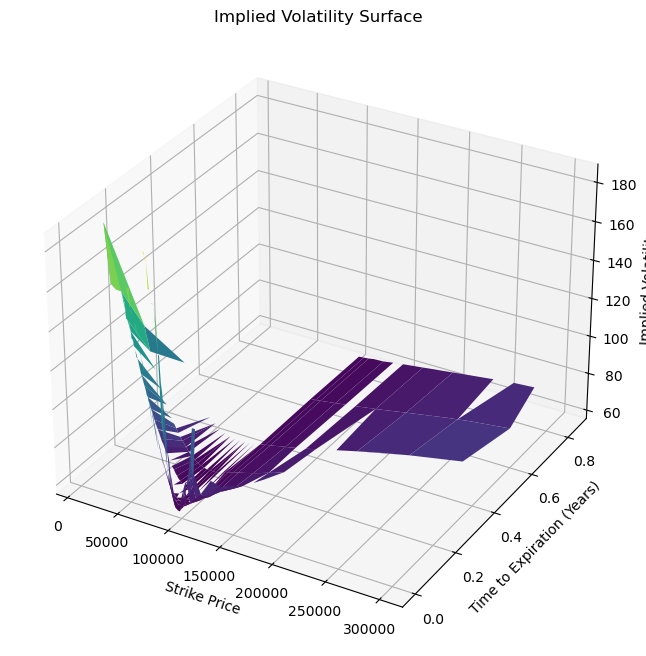

In [18]:
import json
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import datetime

# Function to extract implied volatilities and relevant data from order books
def extract_iv_surface(file_path):
    with open(file_path, "r") as file:
        order_books = json.load(file)

    strike_prices = []
    times_to_expiration = []
    implied_vols = []

    for instrument_name, order_book in order_books.items():
        try:
            # Extract the strike price and expiry date from the instrument name
            parts = instrument_name.split('-')
            strike_price = float(parts[2])  # The strike price is the third part of the instrument name
            expiry_str = parts[1]  # Expiry is the second part of the instrument name

            # Convert expiry date (e.g., '24NOV24') to datetime object
            expiry_date = datetime.datetime.strptime(expiry_str, '%d%b%y')
            current_date = datetime.datetime.now()
            time_to_expiration = (expiry_date - current_date).days / 365  # Time to expiration in years

            iv = order_book.get("mark_iv")
            
            if iv is not None:
                strike_prices.append(strike_price)
                times_to_expiration.append(time_to_expiration)
                implied_vols.append(iv)
        except Exception as e:
            print(f"Error processing instrument {instrument_name}: {e}")

    return np.array(strike_prices), np.array(times_to_expiration), np.array(implied_vols)

# Extract data
strike_prices, times_to_expiration, implied_vols = extract_iv_surface("order_books.json")

# Reshape data for surface plot (Note: This assumes strike_prices and times_to_expiration are structured for a surface)
X, Y = np.meshgrid(np.unique(strike_prices), np.unique(times_to_expiration))
Z = np.zeros_like(X)

for i, strike in enumerate(np.unique(strike_prices)):
    for j, time in enumerate(np.unique(times_to_expiration)):
        # Get corresponding implied volatility
        mask = (strike_prices == strike) & (times_to_expiration == time)
        Z[j, i] = implied_vols[mask][0] if mask.any() else np.nan

# Plot the 3D surface
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')

# Labels and title
ax.set_xlabel('Strike Price')
ax.set_ylabel('Time to Expiration (Years)')
ax.set_zlabel('Implied Volatility')
ax.set_title('Implied Volatility Surface')

plt.show()
